# Association & Sequential Rules algorithms: Validation & Comparison

In this notebook, we will show how to validate the RecPack algorithms using RecPack Pipeline. Metrics will be used here to compare the algorithms.

In [1]:
import numpy as np
import pandas as pd
from recpack.preprocessing.preprocessors import DataFramePreprocessor
from recpack.preprocessing.filters import MinItemsPerUser, MinUsersPerItem
from recpack.scenarios import Timed, TimedLastItemPrediction
from recpack.pipelines import PipelineBuilder

In [2]:
transactions = pd.read_feather('transactions_train_preproc.feather')

In [3]:
transactions

,index,t_dat,customer_id,article_id,price,sales_channel_id,week
0,25784,2018-09-20,1728846800780188,519773001,0.028458,2,0
1,25785,2018-09-20,1728846800780188,578472001,0.032525,2,0
2,5389,2018-09-20,2076973761519164,661795002,0.167797,2,0
3,5390,2018-09-20,2076973761519164,684080003,0.101678,2,0
4,47429,2018-09-20,2918879973994241,662980001,0.033881,1,0
...,...,...,...,...,...,...,...
31788319,31774722,2020-09-22,18439937050817258297,891591003,0.084729,2,104
31788320,31774723,2020-09-22,18439937050817258297,869706005,0.084729,2,104
31788321,31779097,2020-09-22,18440902715633436014,918894002,0.016932,1,104
31788322,31779098,2020-09-22,18440902715633436014,761269001,0.016932,1,104


In [4]:
test_week = transactions.week.max()
transactions = transactions[transactions.week > test_week - 10]

In [5]:
# print the amount of unique customers and articles
print(f'Unique customers: {transactions["customer_id"].nunique()}')
print(f'Unique articles: {transactions["article_id"].nunique()}')

Unique customers: 437365
Unique articles: 38331


# Checking the results of the algorithms:

## `Timed` scenario

### Preprocessing

In [6]:
proc = DataFramePreprocessor(item_ix='article_id', user_ix='customer_id', timestamp_ix='week')
proc.add_filter(MinUsersPerItem(10, item_ix='article_id', user_ix='customer_id'))
proc.add_filter(MinItemsPerUser(10, item_ix='article_id', user_ix='customer_id'))

interaction_matrix = proc.process(transactions)

  0%|          | 0/1228106 [00:00<?, ?it/s]

  0%|          | 0/1228106 [00:00<?, ?it/s]

(array([126710., 131222., 145802., 133000., 122952., 114875., 122603.,
        113551., 113942., 103449.]),
 array([ 95. ,  95.9,  96.8,  97.7,  98.6,  99.5, 100.4, 101.3, 102.2,
        103.1, 104. ]),
 <BarContainer object of 10 artists>)

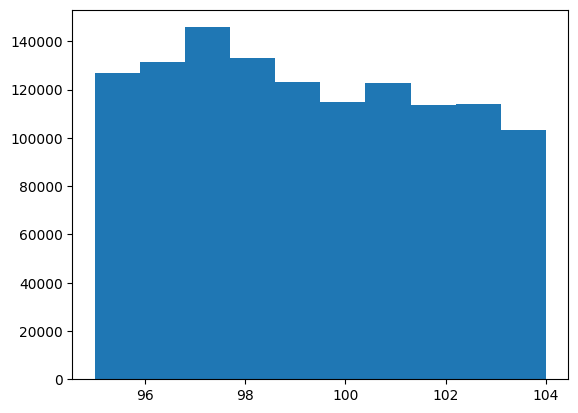

In [7]:
import matplotlib.pyplot as plt
plt.hist(interaction_matrix.timestamps.values)

In [8]:
t_80 = interaction_matrix.timestamps.values[int(0.7 * len(interaction_matrix.timestamps.values))]
t_validate_80 = interaction_matrix.timestamps.values[int(0.7 * 0.7 * len(interaction_matrix.timestamps.values))]
print(t_80, t_validate_80)

101 99


In [9]:
# train on everything < test_week, test on test_week
scenario = Timed(t=t_80, t_validation=t_validate_80 , validation=True)
scenario.split(interaction_matrix)

In [10]:
import pandas
import numpy as np
from scipy.sparse import csr_matrix
from recpack.algorithms.base import TopKItemSimilarityMatrixAlgorithm
from recpack.algorithms.util import invert
from recpack.matrix import InteractionMatrix, to_binary
from recpack.util import get_top_K_values, get_top_K_ranks


#def last_item_recommendations(X: InteractionMatrix):
    
#    return get_top_K_ranks(X.last_timestamps_matrix, K=1)


class AssociationRules(TopKItemSimilarityMatrixAlgorithm):
    def __init__(self, K=200):
        super().__init__(K)

    def _fit(self, X: csr_matrix):
        """
        Trains the predictor.

        """
        X_binary = to_binary(X)
        X_T_binary = csr_matrix(X_binary.transpose())

        # CO_matrix = X_T_binary @ X_binary

        CO_matrix = csr_matrix(X_T_binary @ X_binary)

        # Here we get the best rules
        CO_matrix = get_top_K_values(CO_matrix, self.K)

        # Normalization of CO_matrix
        CO_array = CO_matrix.toarray()

        diag = np.diagonal(CO_array)
        sim_matrix = CO_array/diag[:, None]
        similarity = csr_matrix(sim_matrix)
        # similarity = get_top_K_values(similarity, self.K)

        self.similarity_matrix_ = similarity

    #def _transform_predict_input(self, X):
    #    X = last_item_recommendations(X)
    #    return X

In [11]:
import pandas
import numpy as np
from scipy.sparse import csr_matrix
from recpack.algorithms.base import TopKItemSimilarityMatrixAlgorithm
from recpack.algorithms.util import invert
from recpack.matrix import InteractionMatrix, to_binary
from recpack.util import get_top_K_values, get_top_K_ranks

def last_item_recommendations(X: InteractionMatrix):
    
    return get_top_K_ranks(X.last_timestamps_matrix, K=1)

class AssociationRulesExtensionLastItem(AssociationRules):
    def __init__(self, K=200):
        super().__init__(K)

    def _transform_predict_input(self, X):
        X = last_item_recommendations(X)
        return X

In [12]:
import pandas
import numpy as np
from scipy.sparse import csr_matrix
from recpack.algorithms.base import TopKItemSimilarityMatrixAlgorithm
from recpack.algorithms.util import invert
from recpack.matrix import InteractionMatrix, to_binary
from recpack.util import get_top_K_values, get_top_K_ranks

class AssociationRulesExtension(AssociationRules):
    def __init__(self, K=200, k_items = 200):
        super().__init__(K)
        self.k_items = k_items

    def _transform_predict_input(self, X):
        X = invert(get_top_K_ranks(X.last_timestamps_matrix, K=self.k_items))
        return X

In [13]:
from asyncio.format_helpers import _format_callback_source
import pandas as pd
import numpy as np
from collections import Counter
from itertools import chain
from scipy.sparse import csr_matrix, lil_matrix
from recpack.algorithms.base import ItemSimilarityMatrixAlgorithm
from recpack.algorithms.util import invert
from recpack.matrix import InteractionMatrix, Matrix, to_csr_matrix
from recpack.matrix.interaction_matrix import InteractionMatrix
from recpack.util import to_binary


#def last_item_recommendations(X: InteractionMatrix):
    
#    return get_top_K_ranks(X.last_timestamps_matrix, K=1)


class SequentialRules(ItemSimilarityMatrixAlgorithm):
    def __init__(self, max_steps=20):
        self.max_steps = max_steps

    def _transform_fit_input(self, X: Matrix) -> InteractionMatrix:
        # X_interaction_matrix = isinstance(X, InteractionMatrix)
        if isinstance(X, InteractionMatrix) == False:
            raise ValueError(f"Interaction Matrix")
        elif X.has_timestamps == False:
            raise ValueError(f"requires timestamp information")
        else:
            return X

    def _fit(self, X: InteractionMatrix):
        a = list(X.sorted_item_history)
        sim_matrix = lil_matrix((X.shape[1], X.shape[1]))
        for user, items_per_user in X.sorted_item_history:
            for i in range(0, len(items_per_user) - 1):
                for n_steps, j in enumerate(
                    range(i + 1, min(len(items_per_user), i + self.max_steps + 1)),
                    start=1,
                ):
                    LHS = items_per_user[i]
                    RHS = items_per_user[j]
                    sim_matrix[LHS, RHS] += 1 / n_steps
        support = csr_matrix(X.values.sum(axis=0))

        sim_matrix = sim_matrix.multiply(invert(support).T)
        self.similarity_matrix_ = sim_matrix.tocsr()

    #def _transform_predict_input(self, X):
    #    X = last_item_recommendations(X)
    #    return X

In [14]:
from asyncio.format_helpers import _format_callback_source
import pandas as pd
import numpy as np
from collections import Counter
from itertools import chain
from scipy.sparse import csr_matrix, lil_matrix
from recpack.algorithms.base import ItemSimilarityMatrixAlgorithm
from recpack.algorithms.util import invert
from recpack.matrix import InteractionMatrix, Matrix, to_csr_matrix
from recpack.matrix.interaction_matrix import InteractionMatrix
from recpack.util import to_binary, get_top_K_ranks

def last_item_recommendations(X: InteractionMatrix):
    
    return get_top_K_ranks(X.last_timestamps_matrix, K=1)

class SequentialRulesExtensionLastItem(SequentialRules):
    def __init__(self, max_steps=20, k_items = 200):
        super().__init__(max_steps)
        self.k_items = k_items

    def _transform_predict_input(self, X):
        X = last_item_recommendations(X)
        return X

In [15]:
from asyncio.format_helpers import _format_callback_source
import pandas as pd
import numpy as np
from collections import Counter
from itertools import chain
from scipy.sparse import csr_matrix, lil_matrix
from recpack.algorithms.base import ItemSimilarityMatrixAlgorithm
from recpack.algorithms.util import invert
from recpack.matrix import InteractionMatrix, Matrix, to_csr_matrix
from recpack.matrix.interaction_matrix import InteractionMatrix
from recpack.util import to_binary, get_top_K_ranks


class SequentialRulesExtension(SequentialRules):
    def __init__(self, max_steps=20, k_items = 200):
        super().__init__(max_steps)
        self.k_items = k_items

    def _transform_predict_input(self, X):
        X = invert(get_top_K_ranks(X.last_timestamps_matrix, K=self.k_items))
        return X

In [16]:
from recpack.pipelines import ALGORITHM_REGISTRY, PipelineBuilder, pipeline_builder

ALGORITHM_REGISTRY.register('AssociationRules', AssociationRules)
ALGORITHM_REGISTRY.register('SequentialRules', SequentialRules)
ALGORITHM_REGISTRY.register('AssociationRulesExLast', AssociationRulesExtensionLastItem)
ALGORITHM_REGISTRY.register('SequentialRulesExLast', SequentialRulesExtensionLastItem)
ALGORITHM_REGISTRY.register('AssociationRulesEx', AssociationRulesExtension)
ALGORITHM_REGISTRY.register('SequentialRulesEx', SequentialRulesExtension)

In [17]:
builder = PipelineBuilder()
builder.set_data_from_scenario(scenario)

builder.add_algorithm('AssociationRules', grid={
    'K': [100, 200, 500, 1000, 2000, 5000]  
})

builder.add_algorithm('SequentialRules', grid={
    'max_steps': [10, 20, 30, 50, 100]
})

builder.add_algorithm('AssociationRulesExLast', grid={
    'K': [100, 200, 500, 1000, 2000, 5000]  
})

builder.add_algorithm('SequentialRulesExLast', grid={
    'max_steps': [10, 20, 30, 50, 100]
})

builder.add_algorithm('AssociationRulesEx', grid={
    'K': [100, 200, 500, 1000, 2000, 5000],
    'k_items': [100, 200, 500, 1000, 2000, 5000]
})

builder.add_algorithm('SequentialRulesEx', grid={
    'max_steps': [10, 20, 30, 50, 100],
    'k_items': [100, 200, 500, 1000, 2000, 5000]
})

builder.add_metric('PrecisionK', K=[12, 20, 30, 40])
builder.add_metric('RecallK', K=[12, 20, 30, 40])
builder.add_metric('CoverageK', K=[12, 20, 30, 40])

builder.set_optimisation_metric('RecallK', K=12)

In [18]:
pipeline = builder.build()
pipeline.run()

  0%|          | 0/6 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


2022-12-18 10:48:32,720 - base - recpack - INFO - Fitting AssociationRules complete - Took 18.1s
2022-12-18 10:49:01,219 - base - recpack - INFO - Fitting AssociationRules complete - Took 18.8s
2022-12-18 10:49:34,001 - base - recpack - INFO - Fitting AssociationRules complete - Took 20.7s
2022-12-18 10:50:13,872 - base - recpack - INFO - Fitting AssociationRules complete - Took 24.0s
2022-12-18 10:50:58,187 - base - recpack - INFO - Fitting AssociationRules complete - Took 24.2s
2022-12-18 10:51:46,205 - base - recpack - INFO - Fitting AssociationRules complete - Took 24.4s
2022-12-18 10:52:29,390 - base - recpack - INFO - Fitting AssociationRules complete - Took 19.0s


/opt/conda/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


2022-12-18 10:54:46,994 - base - recpack - INFO - Fitting SequentialRules complete - Took 77.5s


/home/jupyter/recpack/algorithms/base.py:271: UserWarning: SequentialRules missing similar items for 3319 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
/home/jupyter/recpack/algorithms/base.py:119: UserWarning: SequentialRules failed to recommend any items for 3 users
  warnings.warn(f"{self.name} failed to recommend any items " f"for {len(missing)} users")


2022-12-18 10:56:21,193 - base - recpack - INFO - Fitting SequentialRules complete - Took 84.2s
2022-12-18 10:57:57,802 - base - recpack - INFO - Fitting SequentialRules complete - Took 85.1s
2022-12-18 10:59:35,828 - base - recpack - INFO - Fitting SequentialRules complete - Took 85.4s
2022-12-18 11:01:13,831 - base - recpack - INFO - Fitting SequentialRules complete - Took 86.3s
2022-12-18 11:03:21,337 - base - recpack - INFO - Fitting SequentialRules complete - Took 1.16e+02s


/home/jupyter/recpack/algorithms/base.py:271: UserWarning: SequentialRules missing similar items for 1891 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
/home/jupyter/recpack/algorithms/base.py:119: UserWarning: SequentialRules failed to recommend any items for 4 users
  warnings.warn(f"{self.name} failed to recommend any items " f"for {len(missing)} users")


2022-12-18 11:05:02,419 - base - recpack - INFO - Fitting AssociationRulesExtensionLastItem complete - Took 17.4s
2022-12-18 11:05:28,539 - base - recpack - INFO - Fitting AssociationRulesExtensionLastItem complete - Took 18.4s
2022-12-18 11:05:56,898 - base - recpack - INFO - Fitting AssociationRulesExtensionLastItem complete - Took 20.5s
2022-12-18 11:06:28,670 - base - recpack - INFO - Fitting AssociationRulesExtensionLastItem complete - Took 22.6s
2022-12-18 11:07:02,094 - base - recpack - INFO - Fitting AssociationRulesExtensionLastItem complete - Took 24.0s
2022-12-18 11:07:36,614 - base - recpack - INFO - Fitting AssociationRulesExtensionLastItem complete - Took 24.1s
2022-12-18 11:08:12,772 - base - recpack - INFO - Fitting AssociationRulesExtensionLastItem complete - Took 26.3s
2022-12-18 11:10:07,079 - base - recpack - INFO - Fitting SequentialRulesExtensionLastItem complete - Took 78.2s


/home/jupyter/recpack/algorithms/base.py:271: UserWarning: SequentialRulesExtensionLastItem missing similar items for 3319 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
/home/jupyter/recpack/algorithms/base.py:119: UserWarning: SequentialRulesExtensionLastItem failed to recommend any items for 70 users
  warnings.warn(f"{self.name} failed to recommend any items " f"for {len(missing)} users")


2022-12-18 11:11:30,817 - base - recpack - INFO - Fitting SequentialRulesExtensionLastItem complete - Took 81.2s
2022-12-18 11:12:55,734 - base - recpack - INFO - Fitting SequentialRulesExtensionLastItem complete - Took 82.3s
2022-12-18 11:14:24,679 - base - recpack - INFO - Fitting SequentialRulesExtensionLastItem complete - Took 86.2s
2022-12-18 11:15:54,523 - base - recpack - INFO - Fitting SequentialRulesExtensionLastItem complete - Took 87.1s
2022-12-18 11:17:52,145 - base - recpack - INFO - Fitting SequentialRulesExtensionLastItem complete - Took 1.15e+02s


/home/jupyter/recpack/algorithms/base.py:271: UserWarning: SequentialRulesExtensionLastItem missing similar items for 1891 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
/home/jupyter/recpack/algorithms/base.py:119: UserWarning: SequentialRulesExtensionLastItem failed to recommend any items for 91 users
  warnings.warn(f"{self.name} failed to recommend any items " f"for {len(missing)} users")


2022-12-18 11:18:38,411 - base - recpack - INFO - Fitting AssociationRulesExtension complete - Took 17.5s
2022-12-18 11:19:07,149 - base - recpack - INFO - Fitting AssociationRulesExtension complete - Took 18.5s
2022-12-18 11:19:34,645 - base - recpack - INFO - Fitting AssociationRulesExtension complete - Took 17.4s
2022-12-18 11:20:03,547 - base - recpack - INFO - Fitting AssociationRulesExtension complete - Took 18.6s
2022-12-18 11:20:31,284 - base - recpack - INFO - Fitting AssociationRulesExtension complete - Took 17.4s
2022-12-18 11:20:58,990 - base - recpack - INFO - Fitting AssociationRulesExtension complete - Took 17.4s
2022-12-18 11:21:28,451 - base - recpack - INFO - Fitting AssociationRulesExtension complete - Took 18.4s
2022-12-18 11:21:59,220 - base - recpack - INFO - Fitting AssociationRulesExtension complete - Took 18.5s
2022-12-18 11:22:31,263 - base - recpack - INFO - Fitting AssociationRulesExtension complete - Took 18.4s
2022-12-18 11:23:02,639 - base - recpack - INF

/home/jupyter/recpack/algorithms/base.py:271: UserWarning: SequentialRulesExtension missing similar items for 3319 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
/home/jupyter/recpack/algorithms/base.py:119: UserWarning: SequentialRulesExtension failed to recommend any items for 3 users
  warnings.warn(f"{self.name} failed to recommend any items " f"for {len(missing)} users")


2022-12-18 11:46:03,677 - base - recpack - INFO - Fitting SequentialRulesExtension complete - Took 81.8s
2022-12-18 11:47:37,436 - base - recpack - INFO - Fitting SequentialRulesExtension complete - Took 81.6s
2022-12-18 11:49:14,013 - base - recpack - INFO - Fitting SequentialRulesExtension complete - Took 84.3s
2022-12-18 11:50:50,339 - base - recpack - INFO - Fitting SequentialRulesExtension complete - Took 83.9s
2022-12-18 11:52:19,045 - base - recpack - INFO - Fitting SequentialRulesExtension complete - Took 76.0s
2022-12-18 11:53:50,243 - base - recpack - INFO - Fitting SequentialRulesExtension complete - Took 80.5s
2022-12-18 11:55:24,862 - base - recpack - INFO - Fitting SequentialRulesExtension complete - Took 82.7s
2022-12-18 11:56:59,635 - base - recpack - INFO - Fitting SequentialRulesExtension complete - Took 82.6s
2022-12-18 11:58:36,029 - base - recpack - INFO - Fitting SequentialRulesExtension complete - Took 83.6s
2022-12-18 12:00:05,383 - base - recpack - INFO - Fitti

/home/jupyter/recpack/algorithms/base.py:271: UserWarning: SequentialRulesExtension missing similar items for 1891 items.
  warnings.warn(f"{self.name} missing similar items for {missing} items.")
/home/jupyter/recpack/algorithms/base.py:119: UserWarning: SequentialRulesExtension failed to recommend any items for 4 users
  warnings.warn(f"{self.name} failed to recommend any items " f"for {len(missing)} users")


In [19]:
pipeline.optimisation_results

,identifier,params,recallk_12
0,AssociationRules(K=100),{'K': 100},0.022611
1,AssociationRules(K=200),{'K': 200},0.022585
2,AssociationRules(K=500),{'K': 500},0.022612
3,AssociationRules(K=1000),{'K': 1000},0.022437
4,AssociationRules(K=2000),{'K': 2000},0.022378
...,...,...,...
83,"SequentialRulesExtension(k_items=5000,max_step...","{'k_items': 5000, 'max_steps': 10}",0.013698
84,"SequentialRulesExtension(k_items=5000,max_step...","{'k_items': 5000, 'max_steps': 20}",0.013686
85,"SequentialRulesExtension(k_items=5000,max_step...","{'k_items': 5000, 'max_steps': 30}",0.013773
86,"SequentialRulesExtension(k_items=5000,max_step...","{'k_items': 5000, 'max_steps': 50}",0.013794


In [20]:
pd.DataFrame.from_dict(pipeline.get_metrics()).T

,AssociationRules(K=500),SequentialRules(max_steps=100),AssociationRulesExtensionLastItem(K=2000),"SequentialRulesExtensionLastItem(k_items=200,max_steps=30)","AssociationRulesExtension(K=100,k_items=200)","SequentialRulesExtension(k_items=100,max_steps=100)"
precisionk_12,0.008180,0.006297,0.006109,0.004743,0.007894,0.006065
precisionk_20,0.006890,0.005360,0.005038,0.003868,0.006616,0.005153
precisionk_30,0.006051,0.004710,0.004273,0.003388,0.005680,0.004523
precisionk_40,0.005447,0.004305,0.003849,0.003043,0.005081,0.004135
recallk_12,0.015543,0.012167,0.011531,0.009113,0.015110,0.011864
recallk_20,0.021489,0.017008,0.015470,0.012291,0.020712,0.016306
recallk_30,0.027846,0.022094,0.019465,0.015592,0.026296,0.021458
recallk_40,0.033178,0.026865,0.023277,0.018443,0.031089,0.025814
coveragek_12,0.577340,0.775487,0.640861,0.791520,0.638164,0.795185
coveragek_20,0.680257,0.830203,0.701227,0.845320,0.736092,0.847916


In [18]:
# train on everything < test_week - 1, validate on test_week - 1, test on test_week
scenario = TimedLastItemPrediction(t=t_80, t_validation=t_validate_80, validation=True)
scenario.split(interaction_matrix)

/home/jupyter/recpack/scenarios/splitters.py:187: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  max_ts_per_user = data.timestamps.max(level=0)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

/home/jupyter/recpack/matrix/interaction_matrix.py:407: UserWarning: No interaction IDs given, returning empty InteractionMatrix.
  warnings.warn("No interaction IDs given, returning empty InteractionMatrix.")


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [19]:
builder = PipelineBuilder()
builder.set_data_from_scenario(scenario)

builder.add_algorithm('AssociationRules', grid={
    'K': [100, 200, 500, 1000, 2000, 5000]  
})

builder.add_algorithm('SequentialRules', grid={
    'max_steps': [10, 20, 30, 50, 100]
})

builder.add_algorithm('AssociationRulesExLast', grid={
    'K': [100, 200, 500, 1000, 2000, 5000]  
})

builder.add_algorithm('SequentialRulesExLast', grid={
    'max_steps': [10, 20, 30, 50, 100]
})

builder.add_algorithm('AssociationRulesEx', grid={
    'K': [100, 200, 500, 1000, 2000, 5000],
    'k_items': [100, 200, 500, 1000, 2000, 5000]
})

builder.add_algorithm('SequentialRulesEx', grid={
    'max_steps': [10, 20, 30, 50, 100],
    'k_items': [100, 200, 500, 1000, 2000, 5000]
})



builder.add_metric('PrecisionK', K=[12, 20, 30, 40])
builder.add_metric('RecallK', K=[12, 20, 30, 40])
builder.add_metric('CoverageK', K=[12, 20, 30, 40])

builder.set_optimisation_metric('RecallK', K=12)

In [25]:
pipeline = builder.build()
pipeline.run()

  0%|          | 0/2 [00:00<?, ?it/s]

2022-11-26 16:01:05,776 - base - recpack - INFO - Fitting ItemKNN complete - Took 0.88s
2022-11-26 16:01:07,874 - base - recpack - INFO - Fitting ItemKNN complete - Took 0.9s
2022-11-26 16:01:10,167 - base - recpack - INFO - Fitting ItemKNN complete - Took 0.95s
2022-11-26 16:01:12,521 - base - recpack - INFO - Fitting ItemKNN complete - Took 0.981s
2022-11-26 16:01:14,937 - base - recpack - INFO - Fitting ItemKNN complete - Took 1.07s
2022-11-26 16:01:17,664 - base - recpack - INFO - Fitting ItemKNN complete - Took 1.09s
2022-11-26 16:01:20,344 - base - recpack - INFO - Fitting ItemKNN complete - Took 1.15s
2022-11-26 16:01:23,267 - base - recpack - INFO - Fitting ItemKNN complete - Took 1.17s
2022-11-26 16:01:26,271 - base - recpack - INFO - Fitting ItemKNN complete - Took 1.25s
2022-11-26 16:01:29,442 - base - recpack - INFO - Fitting ItemKNN complete - Took 1.26s
2022-11-26 16:01:32,692 - base - recpack - INFO - Fitting ItemKNN complete - Took 1.39s
2022-11-26 16:01:36,262 - base -

In [27]:
pipeline.optimisation_results

,identifier,params,recallk_12
0,"ItemKNN(K=50,normalize_X=True,normalize_sim=Tr...","{'K': 50, 'normalize_X': True, 'normalize_sim'...",0.056492
1,"ItemKNN(K=50,normalize_X=False,normalize_sim=T...","{'K': 50, 'normalize_X': False, 'normalize_sim...",0.076311
2,"ItemKNN(K=60,normalize_X=True,normalize_sim=Tr...","{'K': 60, 'normalize_X': True, 'normalize_sim'...",0.056344
3,"ItemKNN(K=60,normalize_X=False,normalize_sim=T...","{'K': 60, 'normalize_X': False, 'normalize_sim...",0.076014
4,"ItemKNN(K=70,normalize_X=True,normalize_sim=Tr...","{'K': 70, 'normalize_X': True, 'normalize_sim'...",0.056294
...,...,...,...
114,"TARSItemKNN(K=670,fit_decay=0.2,predict_decay=...","{'K': 670, 'fit_decay': 0.2, 'predict_decay': ...",0.091731
115,"TARSItemKNN(K=670,fit_decay=0.2,predict_decay=...","{'K': 670, 'fit_decay': 0.2, 'predict_decay': ...",0.083576
116,"TARSItemKNN(K=670,fit_decay=0.1,predict_decay=...","{'K': 670, 'fit_decay': 0.1, 'predict_decay': ...",0.099244
117,"TARSItemKNN(K=670,fit_decay=0.1,predict_decay=...","{'K': 670, 'fit_decay': 0.1, 'predict_decay': ...",0.094894


In [28]:
pipeline.get_metrics()

,precisionk_12,precisionk_20,precisionk_30,precisionk_40,recallk_12,recallk_20,recallk_30,recallk_40
"ItemKNN(K=50,normalize_X=False,normalize_sim=True,pop_discount=None,similarity=cosine)",0.006263,0.004779,0.003736,0.003153,0.075152,0.095571,0.112066,0.126120
"TARSItemKNN(K=610,fit_decay=0.1,predict_decay=0.3333333333333333,similarity=cosine)",0.008543,0.006171,0.004791,0.003918,0.102519,0.123416,0.143728,0.156722


### Conclusion

The recall@12 is significantly better in the `TimedLastItemPrediction` scenario compared to the `Timed` scenario. However, I was not sure whether this scenario was applicable to our use case, so I went to the recpack documentation on `TimedLastItemPrediction`, which says the following:

*"Predict users’ last interaction, given information about historical interactions. ... The scenario splits the data such that the last interaction of a user is the target for prediction, while the earlier ones are used for training and as history."*

From this description, it seems to me that this scenario is not well-suited for what we are trying to achieve. The goal in the H&M recommendation problem requires us to predict all interactions a user makes in week $t + 1$, given their interaction history up until week $t$. However, the `TimedLastItemPrediction` scenario targets only a single user interaction for prediction, namely the last interaction that a user performs.